# Determine Feature Importance in Light Curves


In [1]:
import os
import pandas as pd
import numpy as np
from settings import SIMULATIONS # list of the simulations
from paths import AFGRUNDIR

figs = os.getcwd() + "/figs_afg/"

In [2]:
# select data
sim = SIMULATIONS["BHBLp_135_135_res150"]
fname = AFGRUNDIR + sim["name"] + '/' + "collated.csv"
df = pd.read_csv(fname, index_col=0)
print(f"File saved: {fname} {print(df.info(memory_usage='deep'))}")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5529600 entries, 0 to 5529599
Data columns (total 9 columns):
 #   Column     Dtype  
---  ------     -----  
 0   eps_e      float64
 1   eps_b      float64
 2   eps_t      float64
 3   p          float64
 4   theta_obs  float64
 5   n_ism      float64
 6   freq       float64
 7   time       float64
 8   flux       float64
dtypes: float64(9)
memory usage: 421.9 MB
None
File saved: /media/vsevolod/T7/work/prj_kn_afterglow/BHBLpTim326_135_135_45km_150mstg_B0_HLLC/collated.csv None


In [3]:
# analyze Data Frame

# check duplicates and missing values
print(f"--- Duplicated_rows --- ")
print(df.duplicated().sum())
print(f"--- Nans rows --- ")
df.isnull().sum()/len(df)

# check df properties
def analyze_df(df : pd.DataFrame)->pd.DataFrame:
    res = pd.DataFrame({
        "is_unique": df.nunique() == len(df),
        "unique": df.nunique(),
        "with_nan":df.isna().any(),
        "percent_nan":round((df.isnull().sum()/len(df))*100,4),
        "dtype":df.dtypes
    })
    return res
analyze_df(df=df)

--- Duplicated_rows --- 
0
--- Nans rows --- 


,is_unique,unique,with_nan,percent_nan,dtype
eps_e,False,4,False,0.0,float64
eps_b,False,4,False,0.0,float64
eps_t,False,4,False,0.0,float64
p,False,4,False,0.0,float64
theta_obs,False,6,False,0.0,float64
n_ism,False,4,False,0.0,float64
freq,False,6,False,0.0,float64
time,False,150,False,0.0,float64
flux,True,5529600,False,0.0,float64


In [4]:
# Convert features to log
log_features = ['eps_e', 'eps_b', 'eps_t', 'n_ism', 'freq', 'flux', 'time']
df[log_features] = df[log_features].apply(np.log10)

In [5]:
# collect peak times and peak fluxes
idx = df.groupby(["eps_e","eps_t","eps_b","n_ism","theta_obs","freq"])["flux"].idxmax()
df_peak = df.loc[idx]
print(df_peak.shape)

(9216, 9)


In [6]:
# Data split
from sklearn.model_selection import train_test_split
X = df_peak.drop(["flux","time"], axis = 1)
y = df_peak['flux']
print(f"X={X.shape} y={y.shape}")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=.25,  # 75% train 25% test
    random_state=42,
    shuffle=True
)
print(f"X_train={X_train.shape} X_test={X_test.shape}")

X=(9216, 7) y=(9216,)
X_train=(6912, 7) X_test=(2304, 7)


---   
# Feature Importance For LC Peak Time and Flux

Source for method: [towardsdatascience](https://towardsdatascience.com/best-practice-to-calculate-and-interpret-model-feature-importance-14f0e11ee660)

RF train accuracy: 0.980
RF test accuracy: 0.981


/tmp/ipykernel_82904/3753930510.py:53: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  permutation_importance_scores().show()


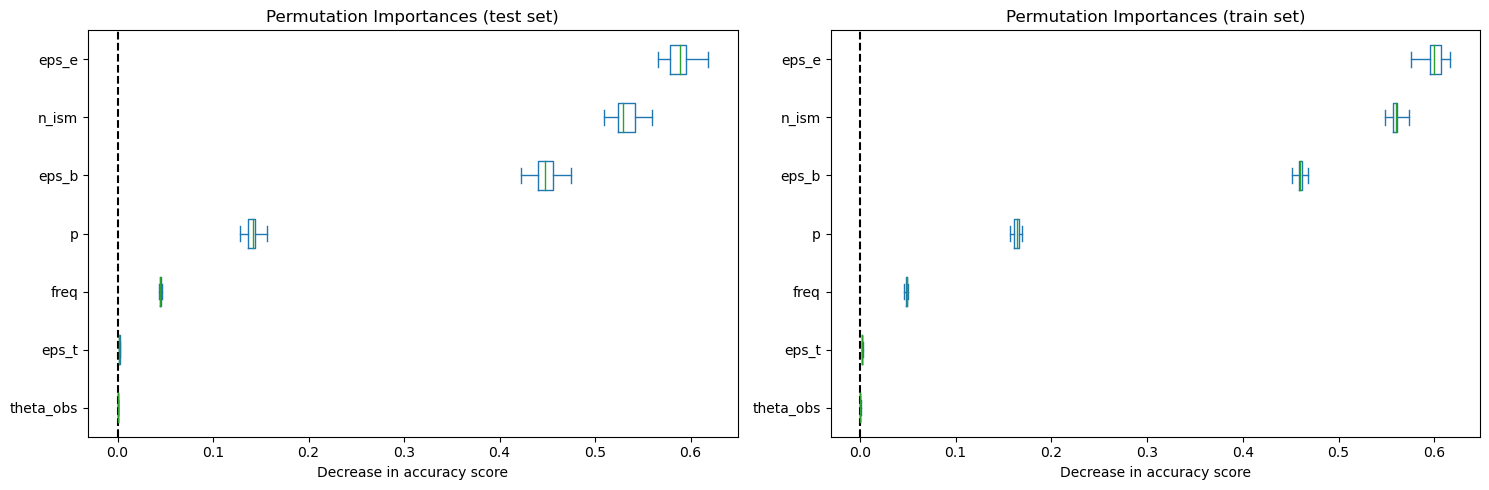

In [7]:
# Attempt to use permutation importance
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.inspection import permutation_importance
def permutation_importance_scores():
    rf = RandomForestRegressor(
        n_estimators=200,
        n_jobs=-1,
        min_samples_leaf = 20,
        oob_score=True,
        random_state = 42)
    rf.fit(X_train, y_train)

    print(f"RF train accuracy: {rf.score(X_train, y_train):.3f}")
    print(f"RF test accuracy: {rf.score(X_test, y_test):.3f}")
    
    #calculate permutation importance for test data 
    result_test = permutation_importance(
        rf, X_test, y_test, n_repeats=20, random_state=42, n_jobs=2
    )
    
    sorted_importances_idx_test = result_test.importances_mean.argsort()
    importances_test = pd.DataFrame(
        result_test.importances[sorted_importances_idx_test].T,
        columns=X.columns[sorted_importances_idx_test],
    )
    
    #calculate permutation importance for training data 
    result_train = permutation_importance(
        rf, X_train, y_train, n_repeats=20, random_state=42, n_jobs=2
    )
    
    sorted_importances_idx_train = result_train.importances_mean.argsort()
    importances_train = pd.DataFrame(
        result_train.importances[sorted_importances_idx_train].T,
        columns=X.columns[sorted_importances_idx_train],
    )
    
    f, axs = plt.subplots(1,2,figsize=(15,5))
    
    importances_test.plot.box(vert=False, whis=10, ax = axs[0])
    axs[0].set_title("Permutation Importances (test set)")
    axs[0].axvline(x=0, color="k", linestyle="--")
    axs[0].set_xlabel("Decrease in accuracy score")
    axs[0].figure.tight_layout()
    
    importances_train.plot.box(vert=False, whis=10, ax = axs[1])
    axs[1].set_title("Permutation Importances (train set)")
    axs[1].axvline(x=0, color="k", linestyle="--")
    axs[1].set_xlabel("Decrease in accuracy score")
    axs[1].figure.tight_layout()
    return f
permutation_importance_scores().show()

RF train accuracy: 0.980
RF test accuracy: 0.981


<AxesSubplot: ylabel='Feature'>

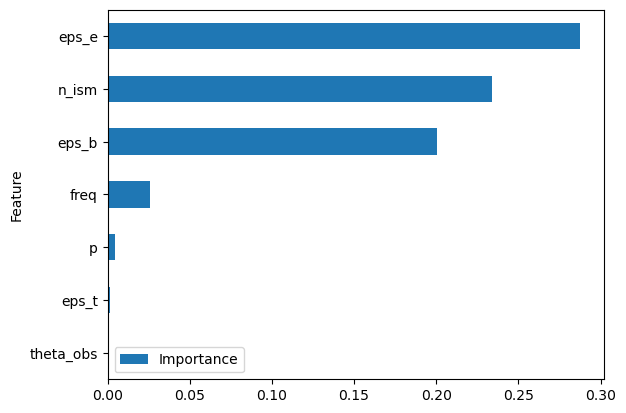

In [8]:
# most accurate way to calculate the feature importances
from sklearn import clone
def dropcol_importances():
    """ 
        calculate the model performance with all predictors 
        and drop a single predictor and see the reduction 
        in the performance. 
        The more important the feature is, the larger the decrease 
        we see in the model performance.
    """
    rf = RandomForestRegressor(
        n_estimators=200,
        n_jobs=-1,
        min_samples_leaf = 20,
        oob_score=True,
        random_state = 42)
    rf.fit(X_train, y_train)
    
    rf_ = clone(rf)
    rf_.random_state = 42
    rf_.fit(X_train, y_train)

    # use out of bag error as performance measurement
    baseline = rf_.oob_score_
    imp = []
    
    for col in X_train.columns:
        # drop a single predictor
        X = X_train.drop(col, axis=1) 
        rf_ = clone(rf)
        rf_.random_state = 42
        rf_.fit(X, y_train)
        o = rf_.oob_score_
        imp.append(baseline - o)
    imp = np.array(imp)
    
    I = pd.DataFrame(
        data={'Feature':X_train.columns, 'Importance':imp})
    I = I.set_index('Feature')
    I = I.sort_values('Importance', ascending=True)

    print(f"RF train accuracy: {rf.score(X_train, y_train):.3f}")
    print(f"RF test accuracy: {rf.score(X_test, y_test):.3f}")
    
    return I
imp = dropcol_importances()
imp.plot(kind = 'barh')

### NOTE:  
permutation importances computed on a random forest model _spread importance_ across collinear variables

In [9]:
# Spearman’s correlation: 
# converts two variables to rank values and then runs 
# Pearson correlation on ranked variables. 
# It doesn’t assume a linear relationship between variables.
from rfpimp import feature_corr_matrix
feature_corr_matrix(X_train)

,eps_e,eps_b,eps_t,p,theta_obs,n_ism,freq
eps_e,1.0000,-0.0034,-0.0036,-0.2076,0.0038,-0.0048,0.0043
eps_b,-0.0034,1.0000,-0.0088,0.2322,-0.0072,-0.0014,-0.0013
eps_t,-0.0036,-0.0088,1.0000,0.4803,0.0072,0.0005,0.0057
p,-0.2076,0.2322,0.4803,1.0000,-0.0140,0.2593,-0.2526
theta_obs,0.0038,-0.0072,0.0072,-0.0140,1.0000,-0.0050,-0.0103
n_ism,-0.0048,-0.0014,0.0005,0.2593,-0.0050,1.0000,0.0003
freq,0.0043,-0.0013,0.0057,-0.2526,-0.0103,0.0003,1.0000


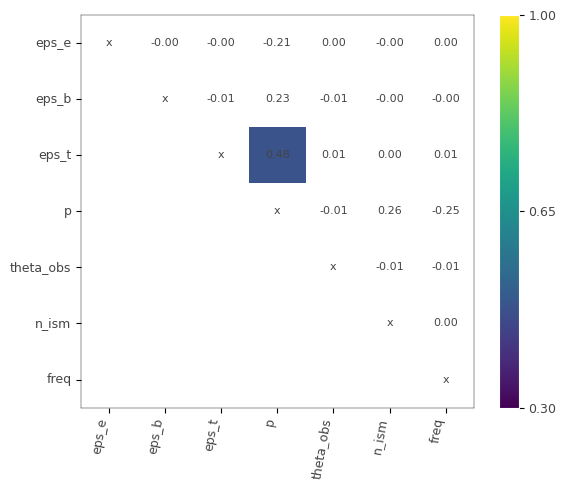

In [10]:
from rfpimp import plot_corr_heatmap
viz = plot_corr_heatmap(X_train, figsize=(7,5), cmap="viridis", color_threshold=0.3)
viz.view()

---
# Using CatBoost to model data   
CatBoost builds upon the theory of decision trees and gradient boosting. 
The main idea of __boosting__ is to sequentially combine many weak models 
(a model performing slightly better than random chance) 
and thus through greedy search create a strong competitive predictive model.  

Because gradient boosting fits the decision trees sequentially, 
the fitted trees will learn from the mistakes of former trees and hence reduce the errors.  

__CatBoost__ grows oblivious trees, which means that the trees are grown by imposing 
the rule that all nodes at the same level, test the same predictor with the same condition, 
and hence an index of a leaf can be calculated with bitwise operations.  

The __oblivious tree procedure__ allows for a simple fitting scheme and efficiency on CPUs, 
while the tree structure operates as a regularization to find an optimal solution and avoid overfitting.

__CatBoost__ is significantly faster than __XGBoost__ and __LightGBM__

### NOTE:
eps_t is highly correlated with $p$, and less so but still with eps_b and eps_e
### Impovements:  
- Remove Highly Collinear Variable


bestTest = 0.603065478
bestIteration = 99

0:	loss: 0.6030655	best: 0.6030655 (0)	total: 329ms	remaining: 31.3s

bestTest = 0.2114409134
bestIteration = 99

1:	loss: 0.2114409	best: 0.2114409 (1)	total: 600ms	remaining: 28.2s

bestTest = 0.6031956202
bestIteration = 99

2:	loss: 0.6031956	best: 0.2114409 (1)	total: 802ms	remaining: 24.9s

bestTest = 0.2114740494
bestIteration = 99

3:	loss: 0.2114740	best: 0.2114409 (1)	total: 1s	remaining: 23s

bestTest = 0.6034129557
bestIteration = 99

4:	loss: 0.6034130	best: 0.2114409 (1)	total: 1.19s	remaining: 21.7s

bestTest = 0.2138590102
bestIteration = 99

5:	loss: 0.2138590	best: 0.2114409 (1)	total: 1.35s	remaining: 20.2s

bestTest = 0.5997558058
bestIteration = 99

6:	loss: 0.5997558	best: 0.2114409 (1)	total: 1.52s	remaining: 19.3s

bestTest = 0.2094892656
bestIteration = 99

7:	loss: 0.2094893	best: 0.2094893 (7)	total: 1.68s	remaining: 18.5s

bestTest = 0.4065979669
bestIteration = 149

8:	loss: 0.4065980	best: 0.2094893 (7)	total: 1.

Text(0.5, 0, 'CatBoost Feature Importance')

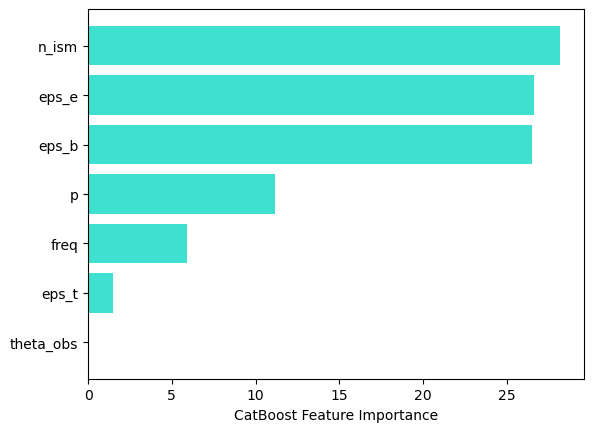

In [11]:
from catboost import CatBoostRegressor, EShapCalcType, EFeaturesSelectionAlgorithm, Pool
from sklearn.metrics import mean_squared_error, r2_score
# CatBoost library integrated tool for combining features and target variables into a train and test dataset. 
# pool constructor will combine numerical and categorical inputs and pass them to the model.
train_pool = Pool(X_train, y_train)
test_pool = Pool(X_test, y_test)
# build a model
model = CatBoostRegressor(loss_function="RMSE",silent=True) # RMSE measure as our loss function (regression task).

grid = {
    'iterations': [100, 150, 200], # number of iterations
    'learning_rate': [0.03, 0.1], # learning rate
    'depth': [2, 4, 6, 8], # tree depth
    'l2_leaf_reg': [0.2, 0.5, 1, 3] # L2 leaf regularization
}
model.grid_search(grid, train_pool)

pred = model.predict(X_test)
rmse = (np.sqrt(mean_squared_error(y_test, pred)))
r2 = r2_score(y_test, pred)
print("Testing performance")
print("RMSE: {:.2f} (lower is better)".format(rmse))
print("R2: {:.2f} (best=1)".format(r2))
# Variable Importance Plot could reveal underlying data structures that might not be visible to the human eye
sorted_feature_importance = model.feature_importances_.argsort()
plt.barh(X_train.keys()[sorted_feature_importance],
         model.feature_importances_[sorted_feature_importance],
         color='turquoise')
plt.xlabel("CatBoost Feature Importance")

#### SHapley Additive exPlanations (SHAP) 
These plots are also a convenient tool to explain the output 
of our machine learning model, by assigning an importance value 
to each feature for a given prediction. SHAP values allow for 
interpreting what features driving the prediction of our target variable.

In the __SHAP__ plot, the features are ranked based on their average absolute 
SHAP and the colors represent the feature value (red high, blue low). 
The higher the SHAP value, the larger the predictor’s attribution. In other words, 
the SHAP values represent a predictor’s responsibility for a change in the model output, 
i.e. prediction of peak flux. This reveals for example that larger eps_e are associated with 
increasing flux while a higher LSTAT is linked with decreasing house prices, which also intuitively makes sense.

In [12]:
import shap
shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

In [13]:
# visualize the first prediction's explanation
shap.plots.force(
    base_value=explainer.expected_value, 
    shap_values=shap_values[0, ...],
    feature_names = X_train.keys()[sorted_feature_importance],
    show=False
)
plt.savefig(figs+"force1.png")
plt.show()

<Figure size 640x480 with 0 Axes>

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


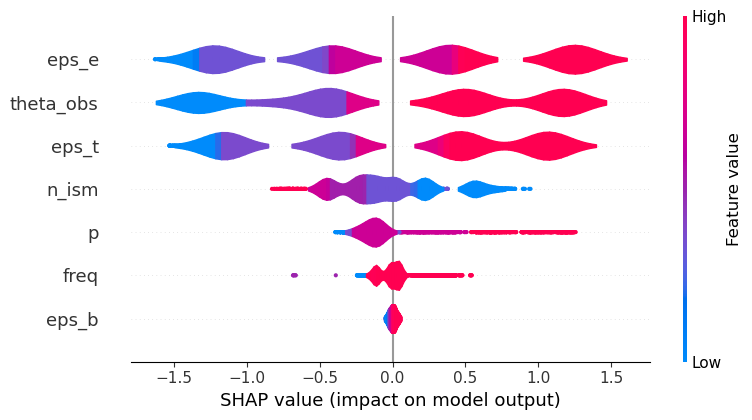

In [14]:
shap.summary_plot(
    shap_values, X_train, 
    feature_names = X_train.keys()[sorted_feature_importance],
    plot_type="violin",
    layered_violin_max_num_bins=20,
    show=False
)
plt.savefig(figs+"summary.png")
plt.show()

In [15]:
# visualize the training set predictions
shap.plots.force(
    base_value=explainer.expected_value,       
    shap_values=shap_values,            
    features=X_train,          
    feature_names=X_train.keys(),
    #matplotlib=True
    show=False
)
plt.savefig(figs+"force2.png")
plt.show()

shap.plots.force is slow for many thousands of rows, try subsampling your data.
Process LokyProcess-1:
Process LokyProcess-2:
Traceback (most recent call last):
  File "/home/vsevolod/anaconda3/envs/PyBlastAfterglow/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/vsevolod/anaconda3/envs/PyBlastAfterglow/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/vsevolod/anaconda3/envs/PyBlastAfterglow/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py", line 432, in _process_worker
    with worker_exit_lock:
  File "/home/vsevolod/anaconda3/envs/PyBlastAfterglow/lib/python3.9/site-packages/joblib/externals/loky/backend/synchronize.py", line 110, in __enter__
    return self._semlock.acquire()
KeyboardInterrupt
Traceback (most recent call last):
  File "/home/vsevolod/anaconda3/envs/PyBlastAfterglow/lib/python3.9/multiprocessing/process.py", line 315, in _boots

KeyboardInterrupt: 

In [ ]:
# create a SHAP dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("MedInc", shap_values.values, X, interaction_index="HouseAge")

In [ ]:
# Use CatBoost

def select_features_syntetic(algorithm: EFeaturesSelectionAlgorithm, steps: int = 1):
    print('Algorithm:', algorithm)
    model = CatBoostRegressor(iterations=2000, random_seed=24)
    summary = model.select_features(
        train_pool,
        eval_set=test_pool,
        features_for_select=list(range(X.shape[1])),     # we will select from all features
        num_features_to_select=1,  # we want to select exactly important features
        steps=steps,                                     # more steps - more accurate selection
        algorithm=algorithm,
        shap_calc_type=EShapCalcType.Regular,            # can be Approximate, Regular and Exact
        train_final_model=True,                          # to train model with selected features
        logging_level='Silent',
        plot=True
    )
    print(f"RF train accuracy: {model.score(X_train, y_train):.3e}")
    print(f"RF test accuracy: {model.score(X_test, y_test):.3e}")
    print('Selected important features: {}'.format(len(summary['selected_features'])))
    return summary
synthetic_shap_summary = select_features_syntetic(algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues)


In [ ]:
synthetic_lfc_summary = select_features_syntetic(algorithm=EFeaturesSelectionAlgorithm.RecursiveByLossFunctionChange)


In [ ]:
print(
    'Features selected by SHAP method and eliminated by LFC method:',
    set(synthetic_shap_summary['selected_features']).difference(synthetic_lfc_summary['selected_features'])
)
print(
    'Features selected by LFC method and eliminated by SHAP method:',
    set(synthetic_lfc_summary['selected_features']).difference(synthetic_shap_summary['selected_features'])
)

In [ ]:
synthetic_pvc_summary = select_features_syntetic(algorithm=EFeaturesSelectionAlgorithm.RecursiveByPredictionValuesChange)


In [ ]:
synthetic_pvc_summary_3_steps = select_features_syntetic(
    algorithm=EFeaturesSelectionAlgorithm.RecursiveByPredictionValuesChange,
    steps=3
)